## Quick and Dirty

### Quick Look at Data

In [1]:
import pandas as pd
import numpy as np
test__file = '/home/ubuntu/wikipedia/DATA/OUTFILE/predicted_enwiki-20161201-pages-meta-history11.xml-p003046514p003201200.7z.tsv'
data = pd.read_csv(test__file, sep='\t')

In [15]:
data.shape

(8261, 19)

In [16]:
data.head()

,Unnamed: 0,byte,comment,text,time,title,user,Added,Added_Bytes,Deleted,Deleted_Bytes,Added_attackModel_logistic_score,Added_aggrModel_logistic_score,Deleted_attackModel_logistic_score,Deleted_aggrModel_logistic_score,Added_attackModel_mlp_score,Added_aggrModel_mlp_score,Deleted_attackModel_mlp_score,Deleted_aggrModel_mlp_score
0,0,274,NaN,Would people object to moving this page to say...,2005-10-31T21:10:06Z,Tom Osborne,Smith03,Would people object to moving this page to say...,222,NaN,0,0.012852,0.010801,0.006179,0.007597,0.031943,0.031943,0.025325,0.025325
1,1,0,Talk:Tom Osborne (football coach) moved to Tal...,Would people object to moving this page to say...,2005-11-02T18:12:52Z,Tom Osborne,Smith03,NaN,0,NaN,0,0.006179,0.007597,0.006179,0.007597,0.025325,0.025325,0.025325,0.025325
2,2,287,Response.,==Article move==\nWould people object to movin...,2005-12-26T05:42:10Z,Tom Osborne,Jareha,Article move Tom Osborne (Nebraska) is definit...,200,NaN,0,0.002757,0.001850,0.006179,0.007597,0.010261,0.010261,0.025325,0.025325
3,3,59,Added activepol,{{activepol|Major candidate in State Governato...,2006-02-14T01:32:58Z,Tom Osborne,68.39.174.238,NaN,0,NaN,0,0.006179,0.007597,0.006179,0.007597,0.025325,0.025325,0.025325,0.025325
4,4,21,NaN,{{Project Congress}}\n{{activepol|Major candid...,2006-05-10T13:24:05Z,Tom Osborne,Sholom,NaN,0,NaN,0,0.006179,0.007597,0.006179,0.007597,0.025325,0.025325,0.025325,0.025325


### Compute the Vector Representations of Words
The Vector representations of words, 300 dimension, are computed using Facebook's FastText

In [107]:
data_subset = data[['Added','Deleted']]
# remove NA
data_subset_noNA = data_subset.dropna(how='all')
# create corpus
data_subset_noNA.head()

,Added,Deleted
0,Would people object to moving this page to say...,NaN
2,Article move Tom Osborne (Nebraska) is definit...,NaN
7,I agree to the move to Thomas W. Osborne.•,NaN
8,Is Tom OSborne running for re-election in 2006...,NaN
9,"No, his running in the gubernatiorial primary ...",NaN


In [108]:
Added = data_subset_noNA.Added.values
Deleted = data_subset_noNA.Deleted.values

In [ ]:
%%time
words = []
import string
for a,d in zip(Added, Deleted):
    # build a list for all the words
    if type(d) is not str: 
        d = ""
    if type(a) is not str:
        a = ""
    a_words = a.split()

    for dw in d.split():
        a_words.append(dw)
    
    sentences = a_words # a list of all words
    for word in sentences:
        cleaned_word =  ''.join(ch for ch in word if ch not in string.punctuation)
        # append unique word into words list
        if(cleaned_word not in words):
            words.append(cleaned_word)

#  save for future use
with open('test__corpus.txt','w') as f:
    for item in words:
        f.write("%s\n"%item)

In [7]:
words = []
with open('test__corpus.txt') as f:
    for line in f:
        words.append(line.strip('\n'))

Load the unique word corpus, and obtain corresponding word vectors

In [164]:
%%time
# load vec
lookup_dict = {}
with open('test__wordvecs.txt') as f:
    for line in f:
        key = line.split()[0]
        values = line.split()[1:]
        lookup_dict[key] = [float(v) for v in values]

CPU times: user 3.43 s, sys: 164 ms, total: 3.6 s
Wall time: 3.46 s


### Compute Document Vectors
Note that while there exist advanced method for computing vector representation of documents, it is computational expensive, and will be used for now.  
For now, we will use vector addition:  
The vector for the document is $\sum \vec{v_{word}}$

In [73]:
%%time
dim = 300
data_noNA = data.dropna(subset=['Added','Deleted'], how='all')
V = np.zeros([data_noNA.shape[0], dim])
i = 0
for row in data_noNA.iterrows():
    content = row[1]
    Added = content['Added']
    Deleted = content['Deleted']
    vec = np.zeros([dim])
    
    # Added word vectors
    try:
        for word in Added.split():
            _vec = lookup_dict.get(word)
            if(_vec is not None):
                vec += _vec
            else:
                vec += np.zeros([dim])
    except AttributeError:
        # the added word is NAN, ignore it
        pass

    # Subtract word vectors
    try:
        for word in Deleted.split():
            _vec = lookup_dict.get(word)
            if(_vec is not None):
                vec -= _vec
            else:
                vec -= np.zeros([dim])
    except AttributeError:
        # the deleted word is NAN, ignore it
        pass
        

    V[i, :] = vec
    i += 1

CPU times: user 7.19 s, sys: 24 ms, total: 7.22 s
Wall time: 7.2 s


In [74]:
V.shape

(6666, 300)

In [75]:
len(lookup_dict.values())

27347

Reduce the dimensionality of words from 300 to 2 using MultiCore T-SNE

In [76]:
%%time
# dimensionality reduction
dim = 2
from MulticoreTSNE import MulticoreTSNE as TSNE
model = TSNE(n_jobs=16, n_components=dim)
vec_tsne = model.fit_transform(V)

CPU times: user 38 s, sys: 236 ms, total: 38.2 s
Wall time: 20 s


In [79]:
vec_tsne.shape

(6666, 2)

In [56]:
# Save it for later use
import pickle
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [80]:
data_noNA['dim1'] = vec_tsne[:,0]
data_noNA['dim2'] = vec_tsne[:,1]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [81]:
data_noNA_subset = data_noNA.drop(['text'], axis=1)
data_noNA_subset.to_csv('/home/ubuntu/wikipedia/Visualization/test__output.csv')

# Result
We plot the result using Tableau for visualization. The image below shows how the document vector varies with time.   
* The article chosen is **Urban renewal**
* the line are connected according to time
* the color of the line represents time variation
* size of line represents the semantics, darker means high attack score

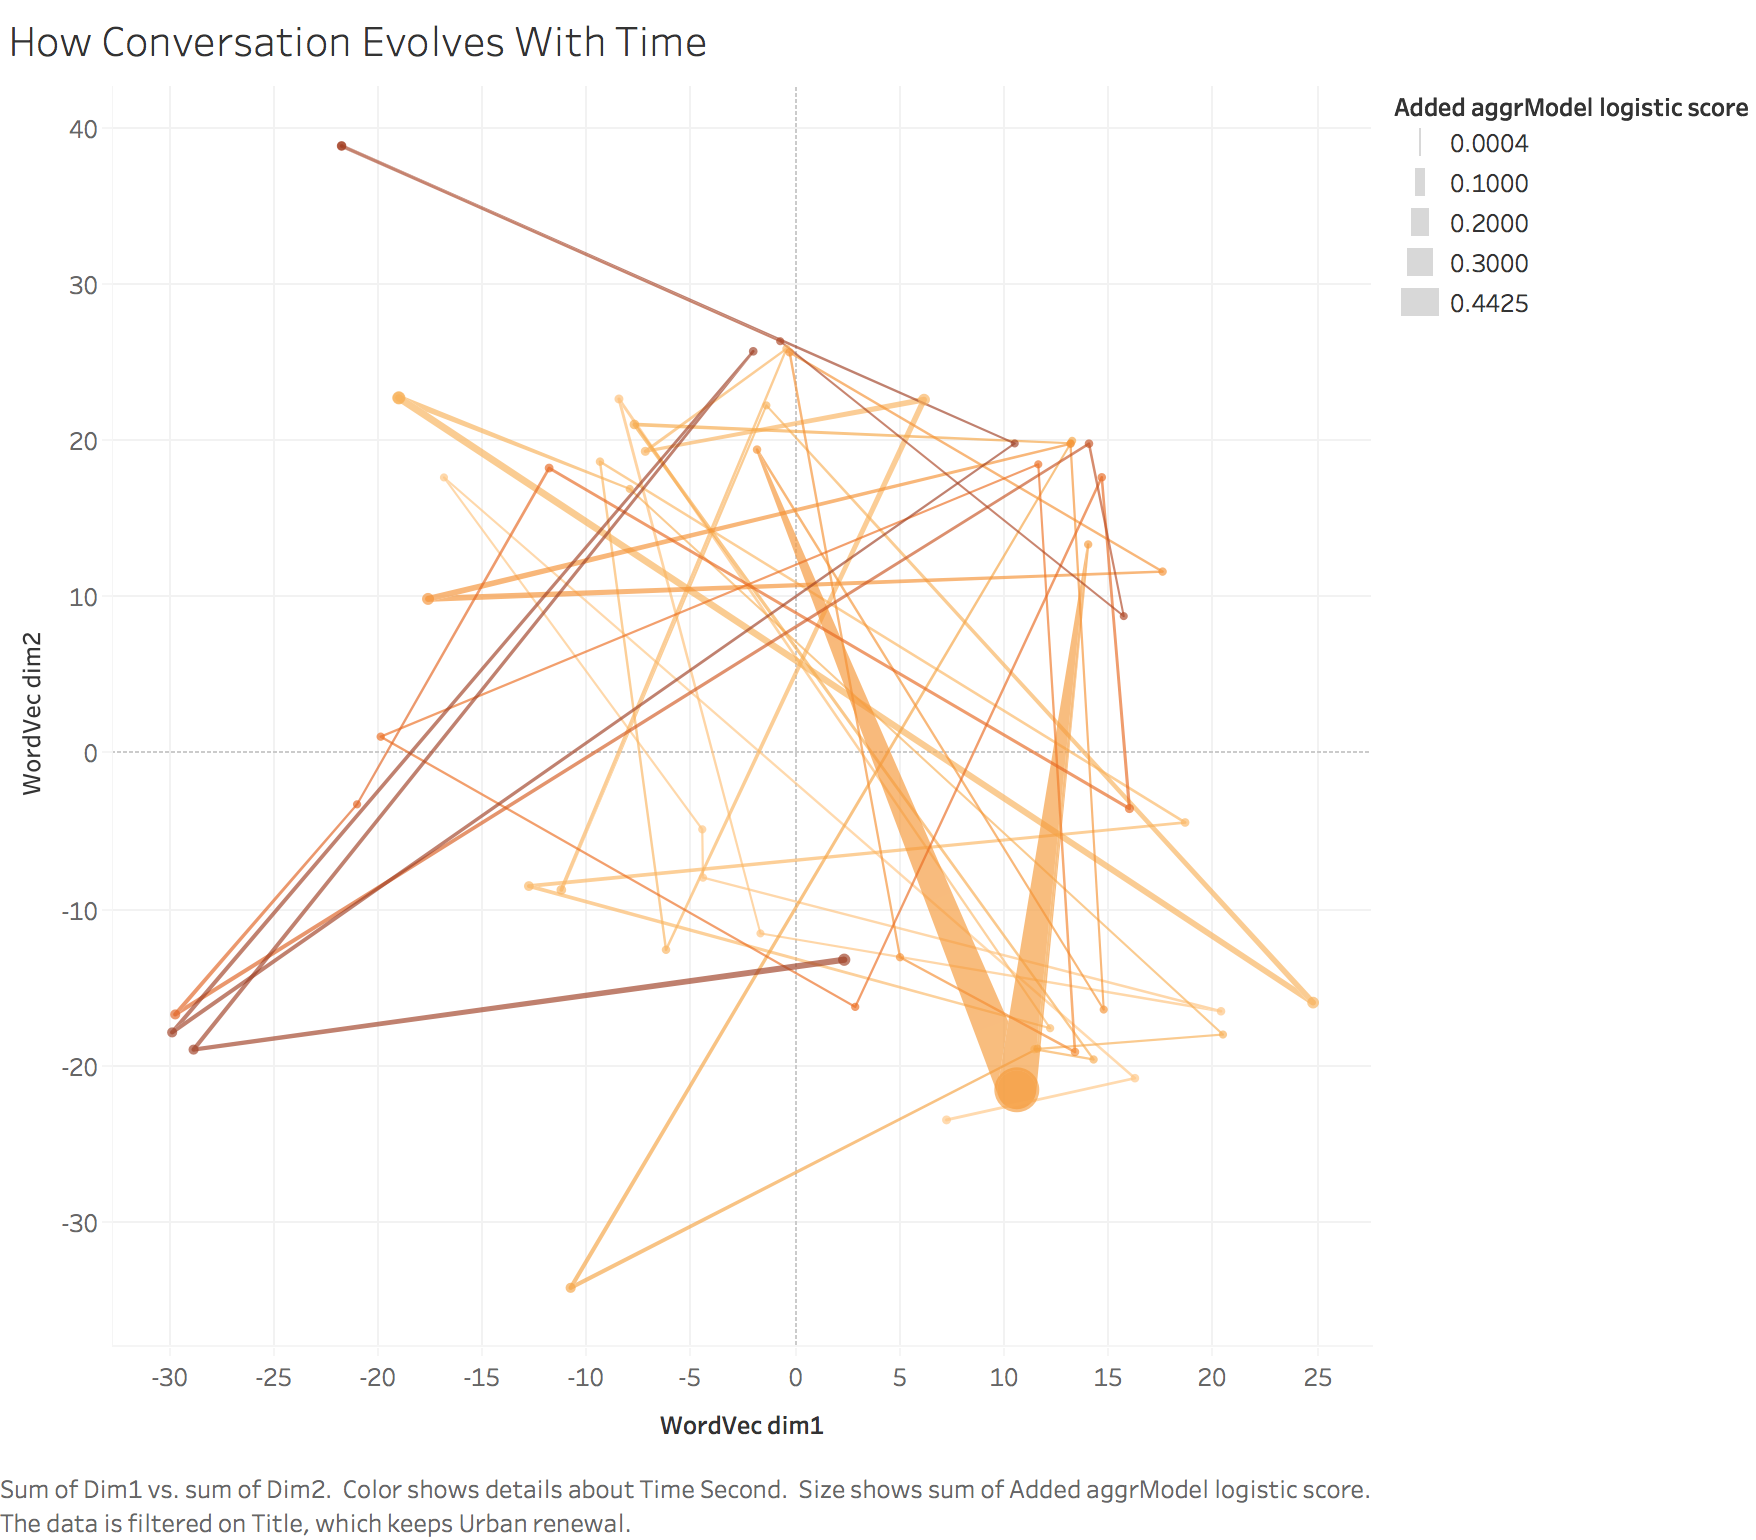

In [15]:
from IPython.display import Image
Image(filename='/home/ubuntu/wikipedia/Visualization/Image6.png')

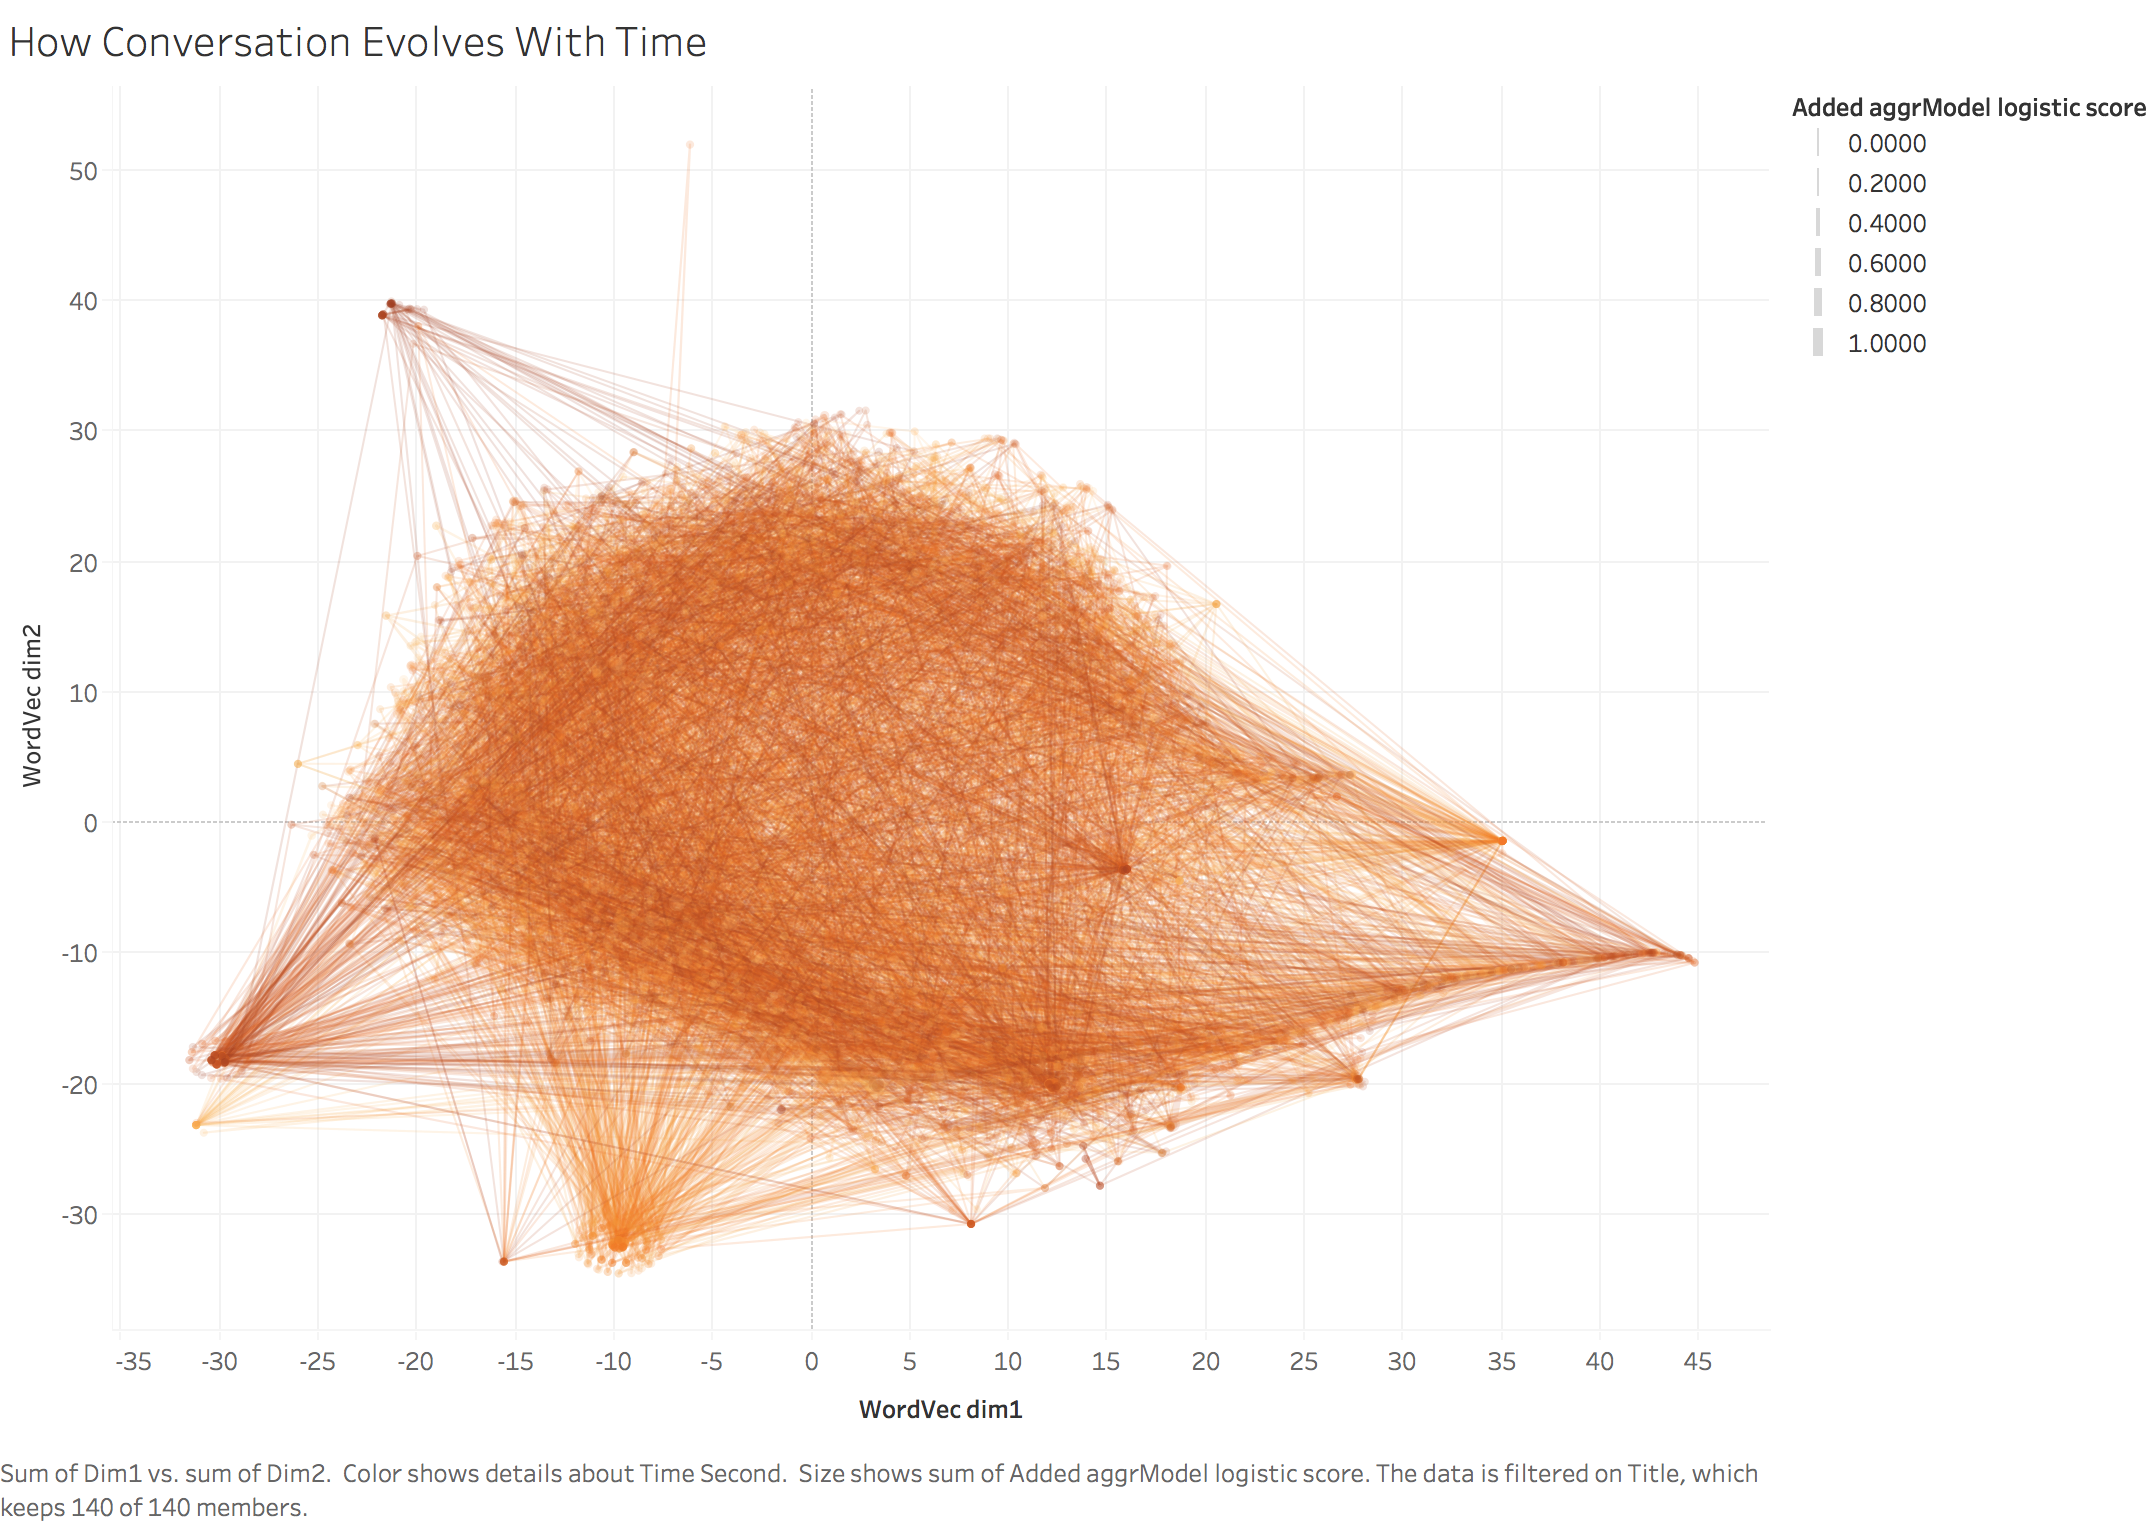

In [18]:
Image(filename='/home/ubuntu/wikipedia/Visualization/Image5.png')